In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pandas.tseries.offsets import BDay 

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Transforming data to DateTime 

In [3]:
fuelPrice = pd.read_csv('C:/ICUP/InformatiCup2018-master/Eingabedaten/Benzinpreise/1.csv', header = None, delimiter = ';', names = ('Time', 'Price'))
index = pd.DatetimeIndex(fuelPrice.Time)
fuelPrice.drop('Time', axis = 1, inplace = True)
fuelPrice.set_index(index, inplace = True)
fuelPrice = fuelPrice['2016':'2017']

# Resample by hour in business days 

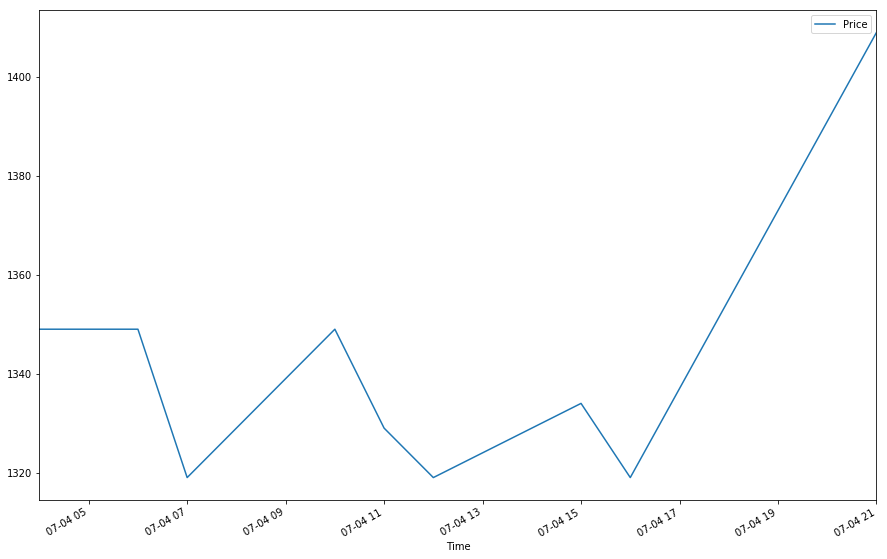

In [4]:
hour_bday_fuelPrice = fuelPrice[fuelPrice.index.dayofweek < 5]
hour_bday_fuelPrice = hour_bday_fuelPrice.resample('H').mean()
hour_bday_fuelPrice.dropna(inplace = True)
hour_bday_fuelPrice['2017-07-04'].plot(figsize=(15, 10))
plt.show()

In [4]:
hour_bday_fuelPrice.shape

(3123, 1)

# Check stationarity using augmented Dickey-Fuller test
If test statistic is more than critical value & p-value is larger than 0.05 than time series is NOT stationary.

In [5]:
def adftest(X):
    test = adfuller(X.iloc[:,0].values)

    print('Test Statistic: ',test[0])
    print('p-value: ',test[1])
    print('Lags: ',test[2])
    print('Observation number: ',test[3])
    print('Critical value 1%: ',test[4]['1%'])
    print('Critical value 5%: ',test[4]['5%'])
    print('Critical value 10%: ',test[4]['10%'])
    #print('Test Statistic: {};{}p-value: {};{}Lags: {};{}Observation number: {};'.format(test[0], '\n', test[1], '\n', test[2], '\n', test[3]))
    #print('Critical value 1%: {};{} Critical value 5%: {};{} Critical value 10% : {}'.format(test[4]['1%'], '\n', test[4]['5%'], '\n', test[4]['10%']))
    if (test[0]>test[4]['1%']) & (test[1]>0.05):
        print ('Time series is not stationary.')
    else:
        print('According to ADF time series is stationary.')
    return

In [6]:
adftest(hour_bday_fuelPrice)

Test Statistic:  -2.29244216145
p-value:  0.174417112454
Lags:  17
Observation number:  3105
Critical value 1%:  -3.43245779851
Critical value 5%:  -2.86247129396
Critical value 10%:  -2.5672657503
Time series is not stationary.


# Decompose time series


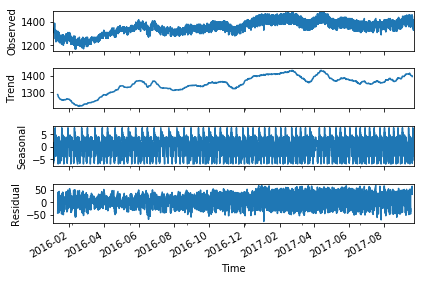

In [7]:
dec = sm.tsa.seasonal_decompose(hour_bday_fuelPrice.interpolate(), freq = 50, model = 'additive')
dec.plot()
plt.show()

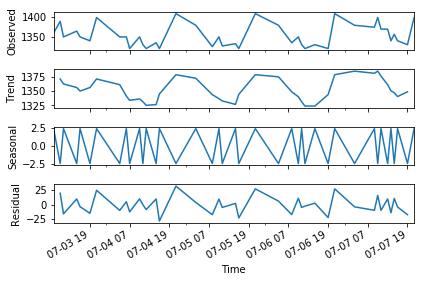

In [8]:
dec2 = sm.tsa.seasonal_decompose(hour_bday_fuelPrice['2017-07-03':'2017-07-07'].interpolate(), freq = 2, model = 'additive')
dec2.plot()
plt.show()

# Plot ACF and PACF

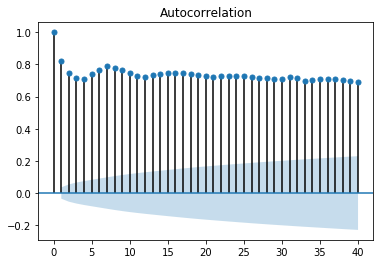

In [9]:
fig = sm.graphics.tsa.plot_acf(hour_bday_fuelPrice, lags = 40)
plt.show()

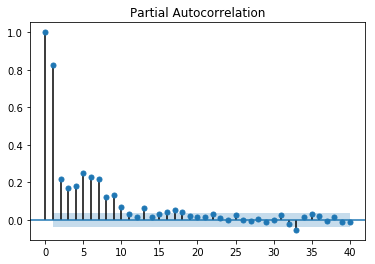

In [10]:
fig = sm.graphics.tsa.plot_pacf(hour_bday_fuelPrice, lags = 40)
plt.show()

# Non-linear log transformation

In [11]:
hour_bday_fuelPrice_log = np.log(hour_bday_fuelPrice)
adftest(hour_bday_fuelPrice_log)

Test Statistic:  -2.2592570581
p-value:  0.185445129152
Lags:  17
Observation number:  3105
Critical value 1%:  -3.43245779851
Critical value 5%:  -2.86247129396
Critical value 10%:  -2.5672657503
Time series is not stationary.


# Plot ACF and PACF

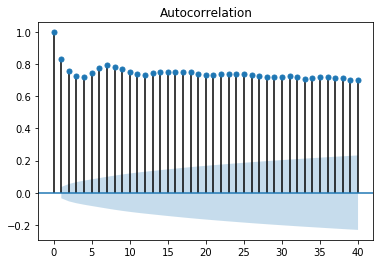

In [12]:
fig = sm.graphics.tsa.plot_acf(hour_bday_fuelPrice_log, lags = 40)
plt.show()

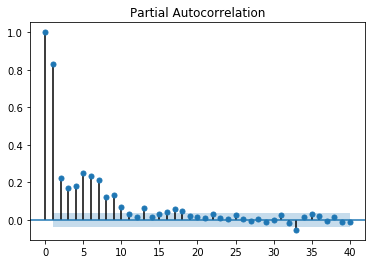

In [13]:
fig = sm.graphics.tsa.plot_pacf(hour_bday_fuelPrice_log, lags = 40)
plt.show()

# Differencing

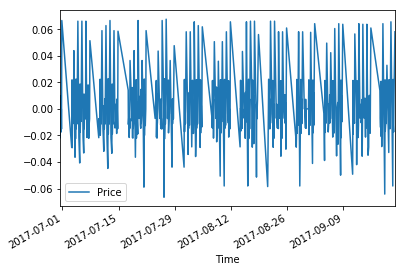

In [14]:
diff = hour_bday_fuelPrice_log - hour_bday_fuelPrice_log.shift()
diff.tail(500).plot()
plt.show()

In [15]:
diff.dropna(inplace = True)
adftest(diff)

Test Statistic:  -21.344000157
p-value:  0.0
Lags:  16
Observation number:  3105
Critical value 1%:  -3.43245779851
Critical value 5%:  -2.86247129396
Critical value 10%:  -2.5672657503
According to ADF time series is stationary.


# Plot ACF and PACF

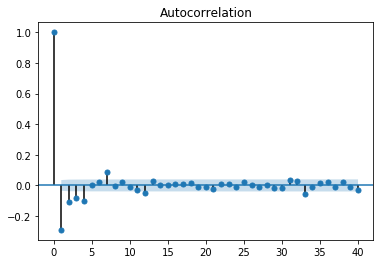

In [16]:
fig = sm.graphics.tsa.plot_acf(diff, lags = 40)
plt.show()

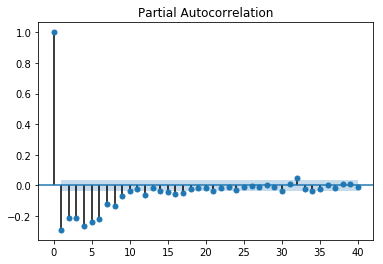

In [17]:
fig = sm.graphics.tsa.plot_pacf(diff, lags = 40)
plt.show()

In [18]:
lag_acf = acf(diff, nlags=10)
lag_pacf = pacf(diff, nlags=10, method='ols')

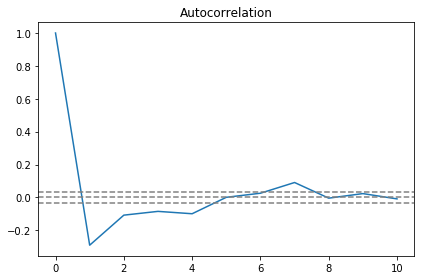

In [19]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Autocorrelation')
plt.tight_layout()
plt.show()

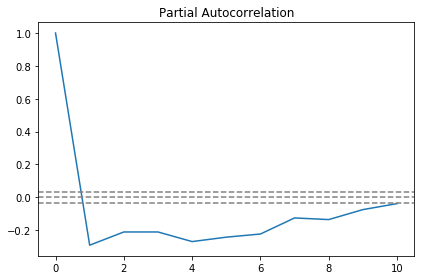

In [20]:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation')
plt.tight_layout()
plt.show()

 #  Calculate order

In [21]:
res = sm.tsa.arma_order_select_ic(diff, ic=['aic', 'bic'])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\ProgramData\Anaconda3\li

In [22]:
res

{'aic':               0             1             2
 0 -14167.743025 -15057.016437 -15314.343977
 1 -14441.424079 -15306.306644 -15318.730998
 2 -14580.576051 -15330.630981 -15307.924374
 3 -14719.721337 -15387.514448 -15427.726976
 4 -14951.573029           NaN -15445.107980,
 'aic_min_order': (4, 2),
 'bic':               0             1             2
 0 -14155.650567 -15038.877750 -15290.159060
 1 -14423.285391 -15282.121728 -15288.499853
 2 -14556.391134 -15300.399835 -15271.646999
 3 -14689.490192 -15351.237073 -15385.403372
 4 -14915.295655           NaN -15396.738147,
 'bic_min_order': (4, 2)}

# Model 

In [23]:
mod = ARIMA(hour_bday_fuelPrice_log, order = (4,2,0)).fit(disp = 0, method = 'css')
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D2.Price   No. Observations:                 3121
Model:                 ARIMA(4, 2, 0)   Log Likelihood                6734.193
Method:                           css   S.D. of innovations              0.028
Date:                Wed, 06 Dec 2017   AIC                         -13456.387
Time:                        11:00:24   BIC                         -13420.119
Sample:                    01-06-2016   HQIC                        -13443.367
                         - 09-21-2017                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           5.262e-07      0.000      0.004      0.997      -0.000       0.000
ar.L1.D2.Price    -0.9852      0.017    -57.452      0.000      -1.019      -0.952
ar.L2.D2.Price    -0.7927      0.023    -35.049      0.000      -0.837      -0.748
ar.L3.D2.Price    -0.5430      0.023    -24.009      0.000      -0.587      -0.499
ar.L4.D2.Price    -0.2910      0.017    -16.970      0.000      -0.325      -0.257
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.2144           -1.3345j            1.3516           -0.2246
AR.2            0.2144           +1.3345j            1.3516            0.2246
AR.3           -1.1474           -0.7514j            1.3715           -0.4077
AR.4           -1.1474           +0.7514j            1.3715            0.4077
-----------------------------------------------------------------------------
"""

# ARIMA residual density

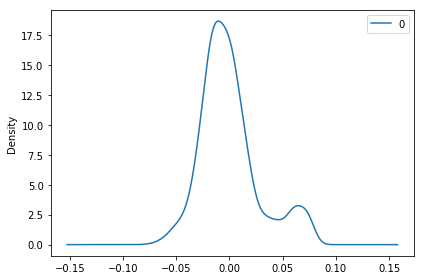

In [24]:
residuals = pd.DataFrame(mod.resid)
residuals.plot(kind='kde')
plt.tight_layout()
plt.show()

In [25]:
residuals.describe()

,0
count,3.117000e+03
mean,2.436643e-08
std,2.789659e-02
min,-7.485554e-02
25%,-1.783295e-02
50%,-4.729240e-03
75%,1.071371e-02
max,8.042029e-02


# In sample predictions

In [26]:
t = hour_bday_fuelPrice_log.as_matrix()
size = int(len(t) - 15)
train,  test = t[0:size], t[size:len(t)]
log = [x for x in train]
predictions = list()
print('Predicted vs Expected:')
for t in range(len(test)):
    mod = ARIMA(log, order = (4,1,0)).fit(disp=0, method = 'css')
    res = mod.forecast()
    yhat = res[0]
    predictions.append(float(yhat))
    obs = test[t]
    log.append(obs)
    print('predicted=%.2f, expected=%.2f' % (np.exp(yhat), np.exp(obs)))


Predicted vs Expected:
predicted=1362.58, expected=1349.00
predicted=1361.78, expected=1394.00
predicted=1378.80, expected=1349.00
predicted=1353.70, expected=1379.00
predicted=1371.48, expected=1364.00
predicted=1362.06, expected=1349.00
predicted=1363.67, expected=1349.00
predicted=1351.09, expected=1329.00
predicted=1346.63, expected=1419.00
predicted=1389.24, expected=1339.00
predicted=1348.88, expected=1369.00
predicted=1361.02, expected=1352.33
predicted=1350.07, expected=1329.00
predicted=1357.14, expected=1339.00
predicted=1340.07, expected=1419.00


# MSE metric 

In [27]:
mean_squared_error(test, predictions)

0.00066935650948354755

# Forecast with ARIMA

In [32]:
H = 100
mod = ARIMA(hour_bday_fuelPrice, order = (4,2,0)).fit(disp=0, method = 'css')
forecasty = mod.forecast(steps = H)
index = pd.date_range(hour_bday_fuelPrice.index[-1], periods = H, freq = 'H')
forecasted_price = pd.DataFrame(forecasty[0], index = index)
hour_bday_fuelPrice_copy = hour_bday_fuelPrice.copy()
hour_bday_fuelPrice_copy = hour_bday_fuelPrice_copy.append(forecasted_price)

In [33]:
print(hour_bday_fuelPrice_copy.tail(H+30))

                           Price            0
2017-09-18 05:00:00  1449.000000          NaN
2017-09-18 07:00:00  1429.000000          NaN
2017-09-18 10:00:00  1459.000000          NaN
2017-09-18 11:00:00  1429.000000          NaN
2017-09-18 13:00:00  1429.000000          NaN
2017-09-18 14:00:00  1389.000000          NaN
2017-09-18 15:00:00  1404.000000          NaN
2017-09-18 16:00:00  1389.000000          NaN
2017-09-18 17:00:00  1359.000000          NaN
2017-09-18 21:00:00  1449.000000          NaN
2017-09-19 08:00:00  1359.000000          NaN
2017-09-19 10:00:00  1389.000000          NaN
2017-09-19 11:00:00  1365.666667          NaN
2017-09-19 13:00:00  1349.000000          NaN
2017-09-19 15:00:00  1364.000000          NaN
2017-09-19 16:00:00  1349.000000          NaN
2017-09-19 21:00:00  1394.000000          NaN
2017-09-20 08:00:00  1349.000000          NaN
2017-09-20 10:00:00  1379.000000          NaN
2017-09-20 11:00:00  1364.000000          NaN
2017-09-20 14:00:00  1349.000000  

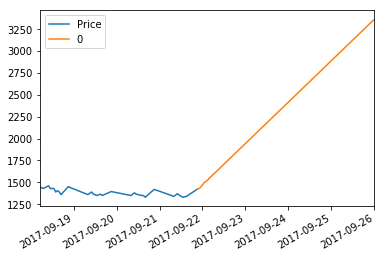

In [35]:
hour_bday_fuelPrice_copy.tail(H+30).plot()
plt.show()